In [1]:
import praw
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm_notebook
import psaw
import sklearn as skl
from sklearn import feature_extraction, pipeline
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download("stopwords")
nltk.download('punkt')

import sys
import unidecode
import functools
import spacy
spacy.prefer_gpu() #enable gpu

from word2number import w2n
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
sns.set_theme(style = "whitegrid")
pd.set_option("display.max_columns",None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# load files
df_all = pd.read_csv("src/data/original_data/AITA_all.csv") # 16000, 33
df_ass = pd.read_csv("src/data/original_data/AITA_ass.csv") # 4421, 33
df_not = pd.read_csv("src/data/original_data/AITA_not.csv") # 10000, 33

df_names = ["df_all", "df_ass","df_not"]
dfs = [df_all, df_ass, df_not]

# remove all samples with no selftext
df_ass = df_ass[df_ass["selftext"] != "[deleted]"]
df_not = df_not[df_not["selftext"] != "[deleted]"]
df_all = df_all[df_all["selftext"] != "[deleted]"]

# reset index
for df in dfs:
    df.reset_index(drop=True, inplace = True)

# from df_all select samples 'link_flair_css_class' with either 'ass' or 'not' 
mask = (df_all["link_flair_css_class"] == "not") | (df_all["link_flair_css_class"] == "ass")
df_all = df_all[mask]
df_all.reset_index(drop = True, inplace = True)

for df_name in df_names:
    print("shape of {}: {}".format(df_name, eval(df_name).shape))

shape of df_all: (6503, 33)
shape of df_ass: (4043, 33)
shape of df_not: (9409, 33)


#### merge all df and remove duplicates

In [9]:
df_meta = pd.concat(dfs) # 30421,33
df_meta.drop_duplicates(ignore_index = True, inplace = True)
df_meta.shape

(23584, 33)

#### drop unwanted columns

In [10]:
# remove columns that are not needed
cols_toremove = ['created_utc', 'subreddit', 'author', 'domain', 'ups','downs', 'saved' , 'from_kind', 'gilded', 
                 'from', 'stickied','retrieved_on','thumbnail', 'subreddit_id', 'hide_score','is_self',
                 'from_id','name','author_flair_css_class', 'author_flair_text', 'quarantine', 'link_flair_text', 'distinguished']
df_meta.drop(columns = cols_toremove, inplace = True)
df_meta.head()

,url,num_comments,score,title,selftext,id,over_18,link_flair_css_class,archived,permalink
0,https://www.reddit.com/r/AmItheAsshole/comment...,9,0,Aita? Me and my friend,Me and my friend had a fight. I felt like I wa...,cum4cl,False,NaN,False,/r/AmItheAsshole/comments/cum4cl/aita_me_and_m...
1,https://www.reddit.com/r/AmItheAsshole/comment...,33,12,AITA for my fantasy football league name?,"My team includes Ted Ginn, Julian Edelman, and...",cum4ob,False,ass,False,/r/AmItheAsshole/comments/cum4ob/aita_for_my_f...
2,https://www.reddit.com/r/AmItheAsshole/comment...,6,2,AITA for not properly greeting my neighbor?,Basically i was getting ready to leave my pare...,cum6kj,False,not,False,/r/AmItheAsshole/comments/cum6kj/aita_for_not_...
3,https://www.reddit.com/r/AmItheAsshole/comment...,10,0,AITA For implying what my boyfriend did was st...,We were reading a similar post on here about a...,cum7pp,False,ass,False,/r/AmItheAsshole/comments/cum7pp/aita_for_impl...
4,https://www.reddit.com/r/AmItheAsshole/comment...,8,2,WIBTA if I don’t help people on the streets out,"Ok so I love to help people, but sometimes idk...",cum9ae,False,not,False,/r/AmItheAsshole/comments/cum9ae/wibta_if_i_do...


#### EDA

In [11]:
# add word counts
df_meta["wordcounts"] = df_meta["selftext"].apply(lambda x: x.replace("\n","")).\
                    apply(lambda x: x.replace("&amp;#x200B;","")).\
                    apply(lambda x: x.replace("&amp;", "and")).\
                    apply(lambda x: len(x.split(" ")))

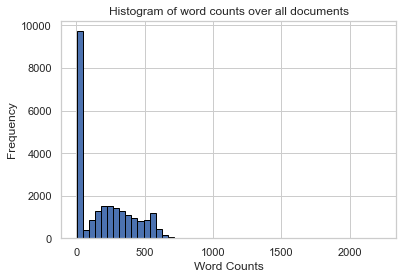

In [12]:
word_counts_per_doc = []
for selftxt in df_meta["selftext"]:
    selftxt = selftxt.replace("\n","")
    selftxt = selftxt.replace("&amp;#x200B;","")
    selftxt = selftxt.replace("&amp;", "and")
    
    word_counts_per_doc.append(len(selftxt.split(" ")))

plt.title("Histogram of word counts over all documents")
plt.hist(word_counts_per_doc, bins = 50, edgecolor = "black");
plt.xlabel("Word Counts")
plt.ylabel("Frequency");

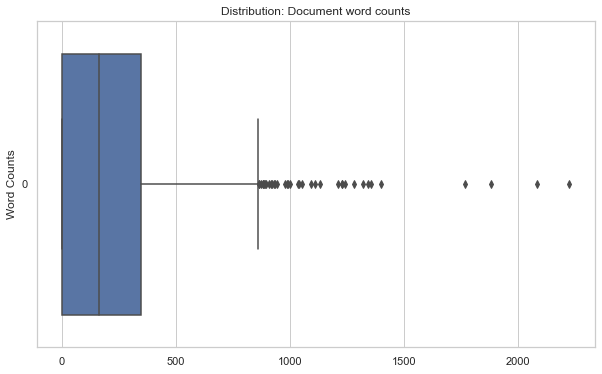

In [14]:
fig = plt.figure(num=1, figsize = (10,6))
sns.boxplot(data = word_counts_per_doc, orient = "h")
plt.title("Distribution: Document word counts")
plt.ylabel("Word Counts");
plt.xlabel("")

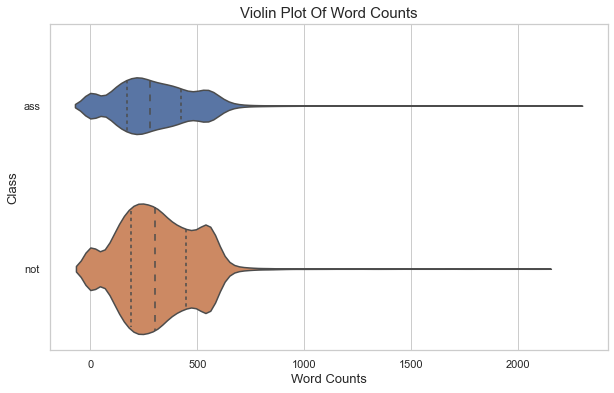

In [32]:
fig = plt.figure(num=1, figsize = (10,6))
plt.title("Violin plot of word counts".title(), fontsize = 15)
sns.violinplot( x = "wordcounts",y = "link_flair_css_class", data = df_meta, scale = "count",
               inner = "quartile", bw = 0.2);
plt.ylabel("Class", fontsize = 13)
plt.xlabel("Word Counts", fontsize = 13);

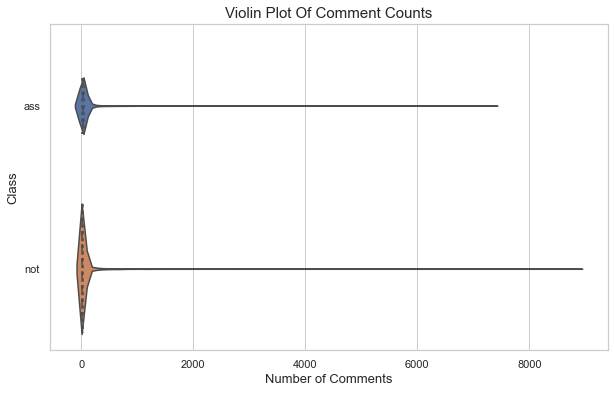

In [30]:
fig = plt.figure(num=1, figsize = (10,6))
plt.title("Violin plot of Comment counts".title(), fontsize= 15)
sns.violinplot( x = "num_comments",y = "link_flair_css_class", data = df_meta, scale = "count", inner = "quartile");
plt.ylabel("Class", fontsize = 13);
plt.xlabel("Number of Comments", fontsize = 13);

#### Explore stopwords

In [35]:
# loading spacy language model
nlp = spacy.load("en_core_web_sm")

In [43]:
nltk_stopwords = set(nltk.corpus.stopwords.words("english"))
spacy_stopwords = nlp.Defaults.stop_words
meta_stopwords = nltk_stopwords | spacy_stopwords

In [44]:
nlp(df_meta["selftext"].values[0])

Me and my friend had a fight. I felt like I was being forgotten. My teacher was making rounds around the classroom and never talked to me. Not once. She kept saying that I need to suck it up and that I'm not the only person there. We had an argument and well...I don't know what's going to happen next...and I'm afraid that were no longer gonna be friends anymore. I need to figure out who's the asshole and who's not. Unless we're both being assholes. I don't want to stop being Friends but I think she might hate me. Please help me. I need it


Edit: Sorry. It wouldn't let me post the full story. I'll update in a minute. I'm really sorry

Edit 2: The fight was about me being dramatic and I should suck it up and such. We've known each other for years and she decided that we should take a break from being friends. So I'm sorry but it wouldn't let me post the full story. Again I'm sorry.

In [45]:
df_meta.iloc[0,:]

url                     https://www.reddit.com/r/AmItheAsshole/comment...
num_comments                                                            9
score                                                                   0
title                                              Aita? Me and my friend
selftext                Me and my friend had a fight. I felt like I wa...
id                                                                 cum4cl
over_18                                                             False
link_flair_css_class                                                  NaN
archived                                                            False
permalink               /r/AmItheAsshole/comments/cum4cl/aita_me_and_m...
wordcounts                                                            172
Name: 0, dtype: object

In [46]:
list(nlp.pipe(df_meta["selftext"].values))[0]

KeyboardInterrupt: 